In [37]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Add mayawaves library to PATH
home_dir = os.path.expanduser('~')
mayawaves_dir = 'repos/mayawaves'
mayawaves_path = os.path.join(home_dir, mayawaves_dir)
sys.path.append(mayawaves_path)

# Import the Coalescence class from mayawaves
# This will allow you to extract information from the simulation
#from mayawaves.utils.postprocessingutils import create_h5_from_simulation
from mayawaves.coalescence import Coalescence

# You can change the path of simulation's .h5 file and the name of the simulation 
h5_path = mayawaves_path + '/example_simulation/'
simulation_name = 'D11_q1_a1_0_0_0_a2_0_0_-0.6_m240'
h5_filename = h5_path + simulation_name + '.h5'

# Create a Coalescence object from the h5 file
example_coalescence = Coalescence(h5_filename)

# Extract information for the two initial black holes and the final black hole
primary_compact_object = example_coalescence.primary_compact_object
secondary_compact_object = example_coalescence.secondary_compact_object
final_compact_object = example_coalescence.final_compact_object

In [38]:
## Choose the quasinormal mode that you will be fitting
l = 2
m = 2
n = 0
psi4 = True  # True for psi4 Weyl scalar; False for gravitational wave strain (h)

In [39]:
## Setup fitting coefficients

# Make sure l is either 2, 3, or 4
try:
    assert l==2 or l==3 or l==4, 'l must equal 2, 3, or 4'
except AssertionError as msg:
    print(msg)
    
# Make sure that m is in the range [-l,l]
try:
    assert -l <= m and m <= l, 'm must be in the range [-l,l]'
except AssertionError as msg:
    print(msg)
        
# Make sure n is either 0, 1, or 2
try:
    assert n==0 or n==1 or n==2, 'n must equal 0, 1, or 2'
except AssertionError as msg:
    print(msg)

    
# Fitting coefficients for quasinormal modes tabulated in Tables VIII, IX, and X of arXiv:gr-qc/0512160

# Initializing the fitting coefficients for l=2,3,4 fundamental modes and overtones, up to n=2
# First index of list will correspond to the "tone" of the mode, n=0 is the fundamental mode, and n>1 are overtones
# Second index of list will correspond to the degree of the mode (Degree 2 is at index 0, Degree 3 is at index 1, and so on)
# Third index of list will correspond to the order of the mode (Order -l is at index 0, Order -l+1 is at index 1, and so on)
# Fourth index of list corresponds to the first, second, or third fitting parameter
freq_fit_coefficients = []
Q_fit_coefficients = []
    
# coefficients for n=0 modes
freq_fit_coefficients.append([[(0.2938, 0.0782, 1.3546), (0.3441, 0.0293, 2.0010), (0.4437, -0.0739, 0.3350), (0.6, -0.2339, 0.4175), (1.5251, -1.1568, 0.1292)],
                                  [(0.4673, 0.1296, 1.3255), (0.5158, 0.08195, 1.4084), (0.5751, 0.02508, 3.1360), (0.5751, 0.02508, 3.1360), (0.6873, -0.09282, 0.3479), (0.8345, -0.2405, 0.4095), (1.1481, -0.5552, 0.3002), (1.8956, -1.3043, 0.1818)],
                                  [(0.6256, 0.1800, 1.3218), (0.6728, 0.1338, 1.3413), (0.7294, 0.07842, 1.5646), (0.7908, 0.02024, 5.4628), (0.9175, -0.1144, 0.3511), (1.0507, -0.2478, 0.4348), (1.2702, -0.4685, 0.3835), (1.6869, -0.8862, 0.2822), (2.3000, -1.5056, 0.2244)]])
    
Q_fit_coefficients.append([[(1.67, 0.4192, 1.47), (2.0, 0.1078, 5.0069), (4.0, -1.9550, 0.1420), (-0.3, 2.3561, -0.2277), (0.7, 1.4187, -0.4990)],
                               [(2.5500, 0.6576, 1.3378), (2.9000, 0.3356, 2.3050), (3.0464, 0.1162, -0.2812), (6.7841, -3.6112, 0.09480), (23.8450, -20.7240, 0.03837), (0.8313, 2.3773, -0.3655), (0.9000, 2.3430, -0.4810)],
                               [(3.4000, 0.8696, 1.4074), (3.700, 0.5829, 1.6681), (4.0000, 0.2777, 2.0647), (4.6000, -0.4038, 0.4629), (7.0000, -2.7934, 0.1708), (14.0000, -9.8240, 0.09047), (-3.6000, 7.7749, -0.1491), (1.4812, 2.8096, -0.4271), (1.1929, 3.1191, -0.4825)]])
    
# coefficients for n=1 modes
freq_fit_coefficients.append([[(0.2528,  0.0921, 1.3344), (0.3165, 0.0301, 2.3415), (0.4185, -0.0768, 0.4355), (0.5800, -0.2416, 0.4708), (1.3673, -1.0260, 0.1628)],
                                  [(0.4413, 0.1387, 1.3178), (0.4951, 0.08577, 1.4269), (0.5584, 0.02514, 3.4154), (0.6687, -0.09155, 0.4021), (0.8105, -0.2342, 0.4660), (1.1226, -0.5471, 0.3264), (1.8566, -1.2818, 0.1934)],
                                  [(0.6061, 0.1869, 1.3168), (0.6562, 0.1377, 1.3456), (0.7154, 0.07979, 1.5852), (0.7785, 0.02005, 5.8547), (0.9028, -0.1127, 0.3843), (1.0337, -0.2439, 0.4695), (1.2462, -0.4580, 0.4139), (1.6722, -0.8843, 0.2923), (2.3000, -1.5173, 0.2271)]])
    
Q_fit_coefficients.append([[(0.4550, 0.1729, 1.3617), (0.6100, 0.0276, 13.1683), (1.2500, -0.6359, 0.1614), (-0.3300, 0.9501, -0.2072), (0.1000, 0.5436, -0.4731)],
                               [(0.7900, 0.2381, 1.3706), (0.9000, 0.1295, 1.6142), (1.2000, -0.1928, 0.1037), (2.0075, -0.9930, 0.12297), (8.8530, -7.8506, 0.03418), (0.2300, 0.8025, -0.3684), (0.2274, 0.8173, -0.4731)],
                               [(1.0800, 0.3095, 1.3279), (1.1800, 0.2111, 1.4129), (1.3200, 0.08694, 4.3255), (1.6000, -0.2323, 0.2306), (2.2000, -0.8308, 0.2023), (4.2000, -2.8399, 0.1081), (-1.5000, 2.8601, -0.1392), (0.4451, 0.9569, -0.4250), (0.3000, 1.1034, -0.4703)]])
    
# coefficients for n=2 modes
freq_fit_coefficients.append([[(0.1873, 0.1117, 1.3322), (0.2696, 0.0315, 2.7755), (0.3734, -0.0794, 0.6306), (0.5660, -0.2740, 0.4960), (1.3223, -1.0257, 0.1860)],
                                  [(0.3933, 0.1555, 1.3037), (0.4567, 0.09300, 1.4469), (0.5271, 0.02561, 3.8011), (0.6343, -0.08915, 0.5117), (0.7684, -0.2252, 0.5805), (1.0989, -0.5550, 0.3569), (1.8004, -1.2558, 0.2133)],
                                  [(0.5686, 0.2003, 1.3068), (0.6244, 0.1454, 1.3513), (0.6885, 0.08259, 1.6136), (0.7549, 0.01985, 6.5272), (0.8751, -0.1096, 0.4516), (1.0019, -0.2374, 0.5397), (1.2025, -0.4401, 0.4769), (1.6526, -0.8888, 0.3081), (2.3000, -1.5397, 0.2321)]])
    
Q_fit_coefficients.append([[(0.1850, 0.1266, 1.3661), (0.2900, 0.0276, 6.4715), (0.5600, -0.2589, 0.3034), (-0.1000, 0.4173, -0.2774), (-0.1000, 0.4206, -0.4256)],
                               [(0.4070, 0.1637, 1.3819), (0.4900, 0.0848, 1.9737), (1.0000, -0.4424, 0.02467), (0.9000, -0.3409, 0.2679), (2.1800, -1.6273, 0.1136), (0.1000, 0.4804, -0.3784), (0.0400, 0.5445, -0.4539)],
                               [(0.5980, 0.2015, 1.3765), (0.6600, 0.1385, 1.3742), (0.7500, 0.05803, 3.7971), (1.6000, -0.8136, 0.03163), (1.2000, -0.4159, 0.2687), (2.2000, -1.4195, 0.1372), (-1.5000, 2.2784, -0.1124), (0.2200, 0.5904, -0.4236), (0.1100, 0.6997, -0.4607)]])
    
# F_lmn = f_1+f_2*(1-j)^f_3
f_1 = freq_fit_coefficients[n][l-2][m+l][0]
f_2 = freq_fit_coefficients[n][l-2][m+l][1]
f_3 = freq_fit_coefficients[n][l-2][m+l][2]
    
# Q_lmn = q_1+q_2*(1-j)^q_3
q_1 = Q_fit_coefficients[n][l-2][m+l][0]
q_2 = Q_fit_coefficients[n][l-2][m+l][1]
q_3 = Q_fit_coefficients[n][l-2][m+l][2]

In [40]:
def qnm_mass_dimensionless_spin_n_0(omega_re, omega_im, l: int, m:int) -> tuple:
    '''
    Function that returns the mass and spin of remnant black hole given the 
    complex frequency of the quasinormal mode

    Args:
        omega_re (float): Real part of quasinormal mode complex frequency
        omega_im (float): Imaginary part of quasinormal mode complex frequency
        l (int): Quasinormal mode number
        m (int): Quasinormal mode number

    Returns:
        mass, j (tuple): The mass and dimensionless spin of the remnant black hole
                         obtained from the quasinormal mode fit

    '''
    
    # Make sure l is either 2, 3, or 4
    try:
        assert l==2 or l==3 or l==4, 'l must equal 2, 3, or 4'
    except AssertionError as msg:
        print(msg)
    
    # Make sure that m is in the range [-l,l]
    try:
        assert -l <= m and m <= l, 'm must be in the range [-l,l]'
    except AssertionError as msg:
        print(msg)

    # Initialize frequency, decay time, and quality factor Q of QNM
    frequency = np.abs(omega_re)/(2*np.pi)
    decay_time = 1/omega_im
    Q = np.pi*frequency*decay_time
    
    # Definitions of fit functions F and Q are given in Appendix E of arXiv:gr-qc/0512160
    
    # Q_lmn = q_1+q_2*(1-j)^q_3
    j = 1-((Q-q_1)/q_2)**(1/q_3) # Final dimensionless spin
    
    # F_lmn = f_1+f_2*(1-j)^f_3
    F = f_1 + f_2*(1-j)**f_3
    
    mass = F/np.abs(omega_re) # Final mass
    return mass, j

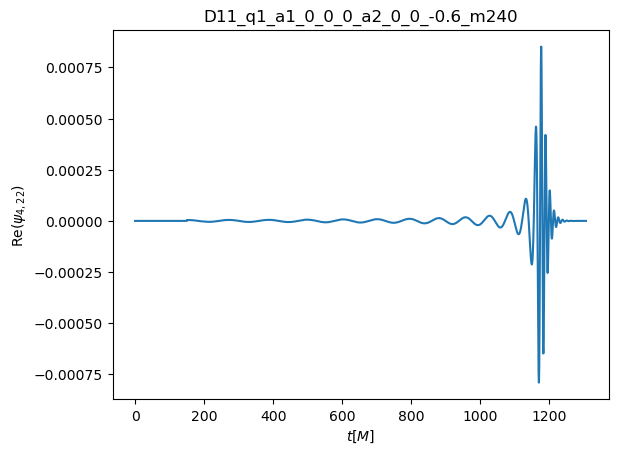

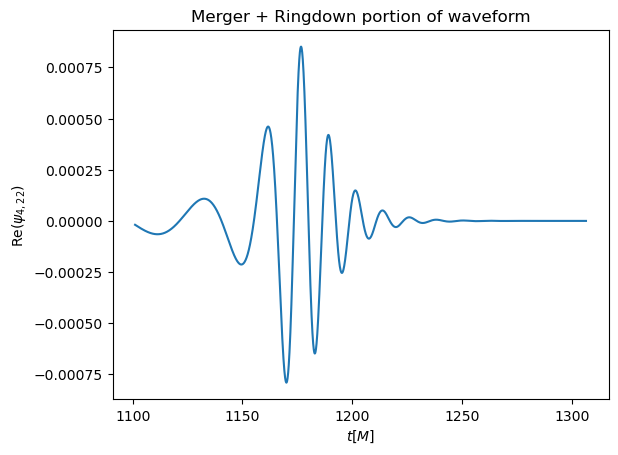

Peak index is at index 17650.00, which is at time t=1176.67


In [41]:
## Plot waveform, see what it looks like, pad the junk radiation

# Grabs time array and real part of Psi4 or strain, depending on which you want to use, for mode with degree l and order m
if(psi4):
    time, data, _ = example_coalescence.psi4_real_imag_for_mode(l, m, extraction_radius=75)
else:
    time, data, _ = example_coalescence.strain_real_imag_for_mode(l, m, extraction_radius=75)
    
# PADDING WITH ZEROS
# Waveform has junk radiation early in its initial phase
# This will pad the junk radiation with zeroes
padding_index = np.where(time - 150 > 0.01)[0][0]
for i in range(0,padding_index):
    data[i] = 0

# Plot the padded waveform
plt.figure()
plt.plot(time,data)
plt.title(r'{0}'.format(simulation_name))
plt.xlabel(r'$t [M]$')
if(psi4):
    plt.ylabel(r'Re($\psi_{{4, {0}{1}}}$)'.format(l, m))
else:
    plt.ylabel(r'Re($h_{{{0}{1}}}$)'.format(l, m))
plt.show()

# Plot merger + ringdown portion of waveform
plt.figure()
plt.plot(time[(time - example_coalescence.merge_time) > 0.01], data[(time - example_coalescence.merge_time) > 0.01])
plt.title(r'Merger + Ringdown portion of waveform')
plt.xlabel(r'$t [M]$')
if(psi4):
    plt.ylabel(r'Re($\psi_{{4, {0}{1}}}$)'.format(l, m))
else:
    plt.ylabel(r'Re($h_{{{0}{1}}}$)'.format(l, m))
plt.show()

# FINDING THE PEAK INDEX
# Finds index of peak time, the time of maximum waveform amplitude
peak_index = np.where(data == np.amax(data))[0][0]
print(f'Peak index is at index {peak_index:.2f}, which is at time t={time[peak_index]:.2f}')

In [42]:
## Perform linear fits of log(amp) and phase data for different time ranges, store R^2 values of fits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.metrics import r2_score

r2_scores_dict = {} # keys will be t_start, values will be R^2 values

for i in range(-25,26):
    t_start = i
    t_end = t_start + 50 # Complete dataset will span 50 M (time is in units of total mass, where M is the total mass)
    start_index = np.where(time - (time[peak_index] + t_start) > 0.01)[0][0]    # Start at t_start M after peak time
    end_index = np.where(time - (time[peak_index] + t_end) > 0.01)[0][0]  # End at t_end M after peak time
    
    # Grab amp and phase of psi4/strain
    if(psi4):
        time, amp, phase = example_coalescence.psi4_amp_phase_for_mode(l, m, extraction_radius=75)
    else:
        time, amp, phase = example_coalescence.strain_amp_phase_for_mode(l, m, extraction_radius=75)

    # Only keep values of time and data that come after merge time
    time_ringdown = time[start_index:end_index]
    amp_ringdown = amp[start_index:end_index]
    log_amp_ringdown = np.log(np.abs(amp_ringdown))
    phase_ringdown = phase[start_index:end_index]
    
    # Shift time so that the time is defined relative to peak time, i.e. peak time starts at time (t-t_peak)/M = 0
    shifted_time_ringdown = time_ringdown - time[peak_index]
    
    # Split the data into train, val, and test
    split_ratio = (0.5, 0.25, 0.25)
    n_train = int(len(shifted_time_ringdown) * split_ratio[0])
    n_val = int(len(shifted_time_ringdown) * split_ratio[1])
    n_test = len(shifted_time_ringdown) - n_train - n_val
    
    time_train, log_amp_train, phase_train = shifted_time_ringdown[:n_train], log_amp_ringdown[:n_train], phase_ringdown[:n_train]
    time_val, log_amp_val, phase_val = shifted_time_ringdown[n_train: n_train + n_val], log_amp_ringdown[n_train: n_train + n_val], phase_ringdown[n_train: n_train + n_val]
    time_test, log_amp_test, phase_test = shifted_time_ringdown[n_train + n_val:], log_amp_ringdown[n_train + n_val:], phase_ringdown[n_train + n_val:]

    ## Plot training, validation, and test datasets
    #plt.figure()
    #plt.plot(time_train, log_amp_train)
    #
    #plt.figure()
    #plt.plot(time_train, phase_train)
    #
    #plt.figure()
    #plt.plot(time_val, log_amp_val)
    #
    #plt.figure()
    #plt.plot(time_val, phase_val)
    #
    #plt.figure()
    #plt.plot(time_test, log_amp_test)
    #
    #plt.figure()
    #plt.plot(time_test, phase_test)
    
    # Fit the training datasets
    polynomial_features_amp = PolynomialFeatures(degree = 1, include_bias = False)
    linear_regression_amp = Ridge(alpha = 0.1)
    pipeline_amp = Pipeline([("pf", polynomial_features_amp), ("lr", linear_regression_amp)])
    pipeline_amp.fit(time_train[:, np.newaxis], log_amp_train)

    polynomial_features_phase = PolynomialFeatures(degree = 1, include_bias = False)
    linear_regression_phase = Ridge(alpha = 0.1)
    pipeline_phase = Pipeline([("pf", polynomial_features_phase), ("lr", linear_regression_phase)])
    pipeline_phase.fit(time_train[:, np.newaxis], phase_train)

    # Predict the validation datasets
    log_amp_pred = pipeline_amp.predict(time_val[:, np.newaxis])
    phase_pred = pipeline_phase.predict(time_val[:, np.newaxis])

    ## Plot the true validation data and the predicted validation data for log(amp) and phase
    #plt.figure()
    #plt.plot(time_val, log_amp_val, 'o')
    #plt.plot(time_val, log_amp_pred)
    #
    #plt.figure()
    #plt.plot(time_val, phase_val, 'o')
    #plt.plot(time_val, phase_pred)
    
    # Compute R^2 values for log(amp) and phase validation data, store the maximum score
    log_amp_r2_score = r2_score(log_amp_val, log_amp_pred)
    phase_r2_score = r2_score(phase_val, phase_pred)
    score = max(log_amp_r2_score, phase_r2_score)
    r2_scores_dict[t_start] = score

In [43]:
## Find largest R^2 value in list, and find corresponding t_start
print(r2_scores_dict)
t_start_best = max(r2_scores_dict, key=r2_scores_dict.get) # Time corresponding to best R^2 value
print(t_start_best)
print(r2_scores_dict[t_start_best]) # R^2 value for t_start_best

{-25: 0.20389397094745942, -24: 0.27815738281652924, -23: 0.3537734106564393, -22: 0.42856561233000745, -21: 0.5010358587992206, -20: 0.5701497874247756, -19: 0.6350010461239424, -18: 0.6944139892194735, -17: 0.7471325929495873, -16: 0.7927252603270817, -15: 0.8316572439905501, -14: 0.8647371873266203, -13: 0.8927218099782005, -12: 0.9160523452543705, -11: 0.9348006830770978, -10: 0.949458369807055, -9: 0.9609407479172832, -8: 0.9700354711217186, -7: 0.9773442793202837, -6: 0.9831489207640761, -5: 0.9875004448519233, -4: 0.9906907049737098, -3: 0.9930960139352282, -2: 0.994975590545678, -1: 0.9964965191737291, 0: 0.9976552534417575, 1: 0.9984331800205788, 2: 0.9989410248679703, 3: 0.9992852547498156, 4: 0.9995328593684693, 5: 0.9997128602050699, 6: 0.9998210122414952, 7: 0.9998727398005461, 8: 0.9998934724874229, 9: 0.9999011712788622, 10: 0.9999060587845583, 11: 0.9999079522172211, 12: 0.9999018246837926, 13: 0.9998878543950583, 14: 0.9998712646414866, 15: 0.9998590740726806, 16: 0.99

0.9999893115078528


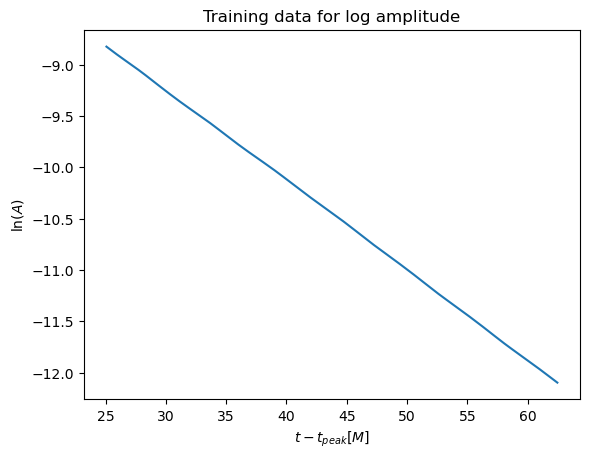

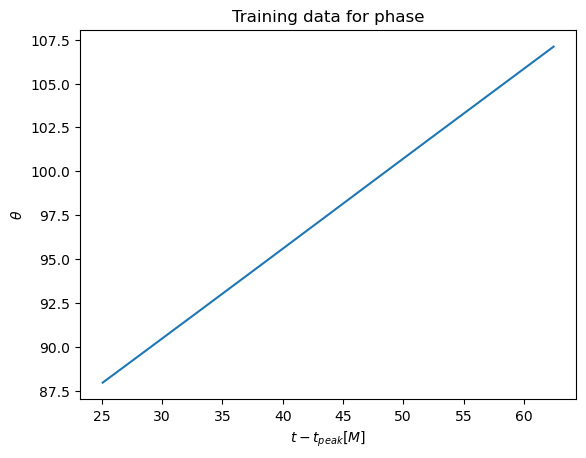

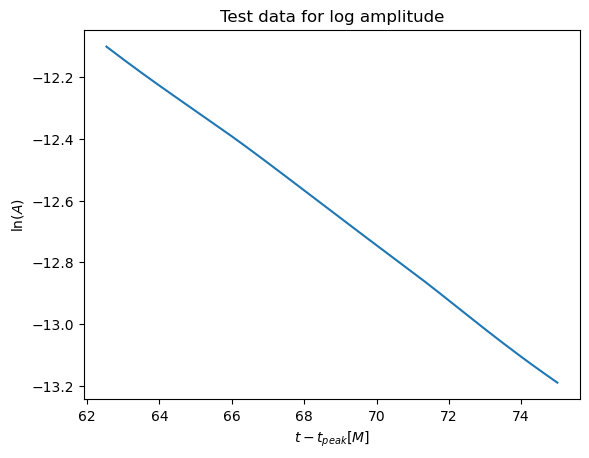

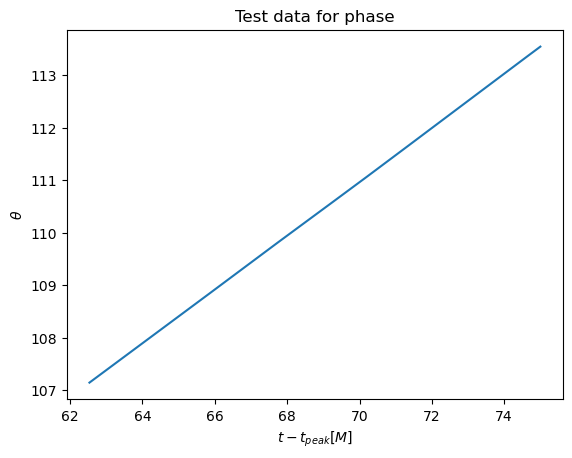

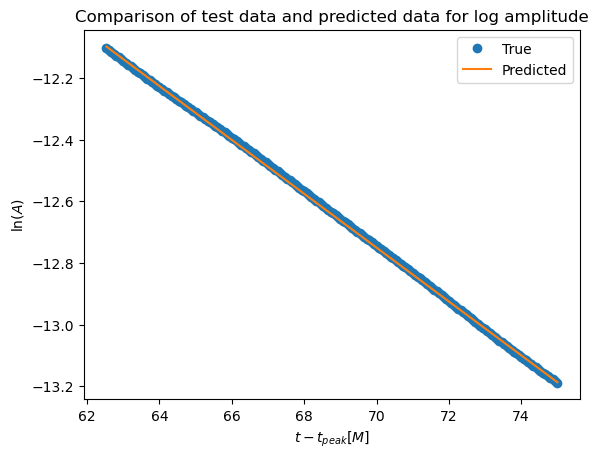

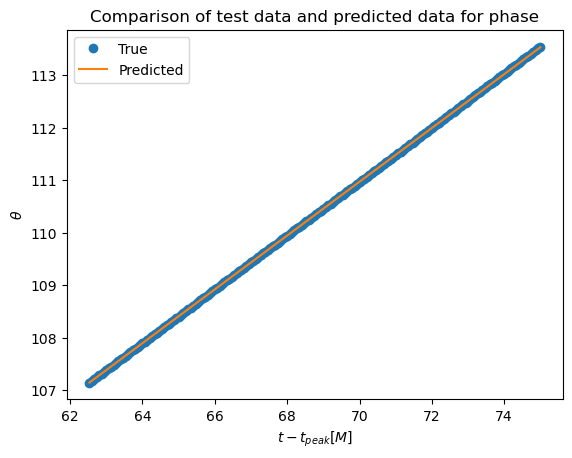

In [44]:
## Do one iteration of loop using t_start_best

t_start = t_start_best
t_end = t_start + 50 # Complete dataset will span 50 M (time is in units of mass, and M is 1 solar mass)
start_index = np.where(time - (time[peak_index] + t_start) > 0.01)[0][0]    # Start at t_start M after peak time
end_index = np.where(time - (time[peak_index] + t_end) > 0.01)[0][0]  # End at t_end M after peak time

# Grab amp and phase of psi4/strain
if(psi4):
    time, amp, phase = example_coalescence.psi4_amp_phase_for_mode(l, m, extraction_radius=75)
else:
    time, amp, phase = example_coalescence.strain_amp_phase_for_mode(l, m, extraction_radius=75)
    
# Only keep values of time and data that come after merge time
time_ringdown = time[start_index:end_index]
amp_ringdown = amp[start_index:end_index]
log_amp_ringdown = np.log(np.abs(amp_ringdown))
phase_ringdown = phase[start_index:end_index]

# Shift time so that the time is defined relative to peak time, i.e. peak time starts at time (t-t_peak)/M = 0
shifted_time_ringdown = time_ringdown - time[peak_index]

# Split the data into train, val, and test
split_ratio = (0.75, 0.25)
n_train = int(len(shifted_time_ringdown) * split_ratio[0])
n_test = len(shifted_time_ringdown) - n_train

time_train, log_amp_train, phase_train = shifted_time_ringdown[:n_train], log_amp_ringdown[:n_train], phase_ringdown[:n_train]
time_test, log_amp_test, phase_test = shifted_time_ringdown[n_train:], log_amp_ringdown[n_train:], phase_ringdown[n_train:]

# Plot training, validation, and test datasets
plt.figure()
plt.plot(time_train, log_amp_train)
plt.title(r'Training data for log amplitude')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'ln$(A)$')

plt.figure()
plt.plot(time_train, phase_train)
plt.title(r'Training data for phase')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'$\theta$')


plt.figure()
plt.plot(time_test, log_amp_test)
plt.title(r'Test data for log amplitude')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'ln$(A)$')

plt.figure()
plt.plot(time_test, phase_test)
plt.title(r'Test data for phase')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'$\theta$')

# Fit the training datasets
polynomial_features_amp = PolynomialFeatures(degree = 1, include_bias = False)
linear_regression_amp = Ridge(alpha = 0.1)
pipeline_amp = Pipeline([("pf", polynomial_features_amp), ("lr", linear_regression_amp)])
pipeline_amp.fit(time_train[:, np.newaxis], log_amp_train)

polynomial_features_phase = PolynomialFeatures(degree = 1, include_bias = False)
linear_regression_phase = Ridge(alpha = 0.1)
pipeline_phase = Pipeline([("pf", polynomial_features_phase), ("lr", linear_regression_phase)])
pipeline_phase.fit(time_train[:, np.newaxis], phase_train)

# Predict the validation datasets
log_amp_pred = pipeline_amp.predict(time_test[:, np.newaxis])
phase_pred = pipeline_phase.predict(time_test[:, np.newaxis])

# Plot the true validation data and the predicted validation data for log(amp) and phase
plt.figure()
plt.plot(time_test, log_amp_test, 'o', label = 'True')
plt.plot(time_test, log_amp_pred, label = 'Predicted')
plt.title('Comparison of test data and predicted data for log amplitude')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'ln$(A)$')
plt.legend()

plt.figure()
plt.plot(time_test, phase_test, 'o', label = 'True')
plt.plot(time_test, phase_pred, label = 'Predicted')
plt.title('Comparison of test data and predicted data for phase')
plt.xlabel(r'$t-t_{peak}[M]$')
plt.ylabel(r'$\theta$')
plt.legend()

# Compute R^2 values for log(amp) and phase validation data, store the maximum score
log_amp_r2_score = r2_score(log_amp_test, log_amp_pred)
phase_r2_score = r2_score(phase_test, phase_pred)
score = max(log_amp_r2_score, phase_r2_score)
print(score)

In [45]:
# Computing fractional root-mean-square error
def frac_rms_error(coalescence_object, ringdown_time, start_index, end_index, A_fit, omega_re_fit, omega_im_fit, phi_fit, l: int, m:int):
    '''
    Function that computes the fractional root-mean-square error of the quasinormal mode fit

    Args:
        coalescence_object (Coalescence): Contains all information of the simulation
        ringdown_time (array): Time array of ringdown portion of simulation
        start_index (int): Index of simulation's time array that marks beginning of ringdown regime
        end_index (int): Index of simulation's time array that marks end of ringdown regime
        A_fit (float): Amplitude obtained from fit
        omega_re_fit (float): Real part of quasinormal mode complex frequency obtained from fit
        omega_im_fit (float): Imaginary part of quasinormal mode complex frequency obtained from fit
        phi_fit (float): Phase shift obtained from fit
        l (int): Quasinormal mode number
        m (int): Quasinormal mode number

    Returns:
        result (float): The fractional root-mean-square error
    '''

    import math

    # Get portion of NR waveform in ringdown time interval
    temp, data, _ = coalescence_object.psi4_real_imag_for_mode(l, m, extraction_radius=75)
    NR = data[start_index:end_index] # NR waveform during ringdown

    def _qnm_fit(t, A, omega_im, omega_re, phi):
        '''
        Function that plots a quasinormal mode using information from the
        amplitude, phase shift, and complex frequency

        Args:
            t (array): Time array
            A (float): Amplitude of quasinormal mode
            omega_im (float): Imaginary part of quasinormal mode complex frequency
            omega_re (float): Real part of quasinormal mode complex frequency
            phi (float): Phase shift of quasinormal mode

        Returns:
            qnm (array): Quasinormal mode fit
        '''
        qnm = A * np.exp(-omega_im * t) * np.cos(omega_re * t + phi)
        return qnm

    # Construct fit from fit parameters during ringdown time interval
    Fit = _qnm_fit(ringdown_time, math.exp(A_fit), omega_im_fit, omega_re_fit, phi_fit)
    
    plt.figure(1)
    plt.plot(ringdown_time, NR, 'k-', label = 'NR')
    plt.plot(ringdown_time, Fit, 'r--', label = 'Fit')
    plt.legend()
    plt.xlabel(r'$t-t_{peak}[M]$')
    if(psi4):
        plt.ylabel(r'Re($\psi_{{4, {0}{1}}}$)'.format(l, m))
        plt.title(r'QNM fit to real part of $\psi_{{4, {0}{1}}}$'.format(l, m))
    else:
        plt.ylabel(r'Re($h_{{{0}{1}}}$)'.format(l, m))
        plt.title(r'QNM fit to real part of $h_{{{0}{1}}}$'.format(l, m))
    plt.show()
       
    def _time_average(data, time):
        '''
        Define a function that computes the time average of data over a given interval of time

        Args:
            data (array): Data array
            time (array): Time array

        Returns:
            Time average of data (float)
        '''
        t_initial = time[0]
        t_final = time[len(time)-1]
        delta = t_final - t_initial
        integral = np.trapz(data, x = time)
        return 1/delta * integral
    
    # Compute numerator of error equation
    nr_fit_sq_diff = np.square(NR-Fit)
    num = _time_average(nr_fit_sq_diff, ringdown_time)
    
    # Compute denominator of error equation
    nr_sq = np.square(NR)
    denom = _time_average(nr_sq, ringdown_time)
    
    # Return fractional root-mean-square error
    result = math.sqrt(abs(num/denom))
    return result

Best start time is 25 M after merger, or t = 1201.67 M
omega_re from linear fit = 0.5126
omega_im from linear fit = 0.0875
Mass from EB fitting functions = 0.9677
Dimensionless spin from EB fitting functions = 0.5956
Final Mass from apparent horizon = 0.9583
Final dimensionless spin from apparent horizon = 0.5922
Mass percent error = 0.97%
Spin percent error = 0.57%


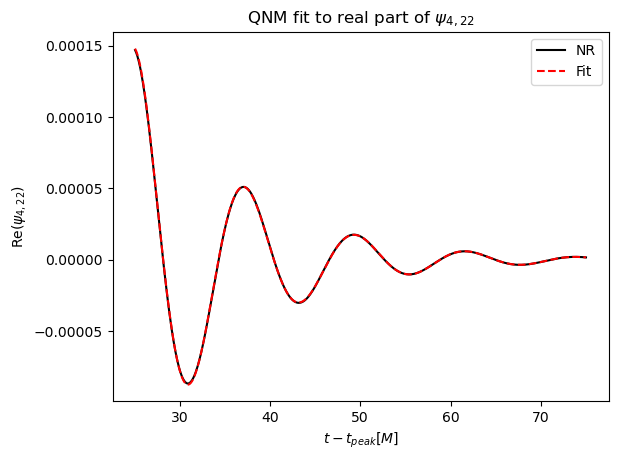

Fractional root-mean-square error =  0.009
R^2 score for model is 0.99999


In [46]:
## Output final mass and spin, compare to horizon final mass and spin

print(f'Best start time is {t_start_best} M after merger, or t = {t_start_best + time[peak_index]:.2f} M')

# Compute the final mass, dimensionless spin, and their uncertainties using EB fitting functions and QNM from single mode fit
# mass, dimensionless_spin, delta_mass, delta_dimensionless_spin = qnm_mass_dimensionless_spin_n_0(omega_re, omega_im, delta_omega_re, delta_omega_im, l, m)
omega_im = -pipeline_amp.named_steps['lr'].coef_[0]
omega_re = pipeline_phase.named_steps['lr'].coef_[0]
intercept1 = pipeline_amp.named_steps['lr'].intercept_
intercept2 = pipeline_phase.named_steps['lr'].intercept_

mass, dimensionless_spin = qnm_mass_dimensionless_spin_n_0(omega_re, omega_im, l, m)

print(f'omega_re from linear fit = {omega_re:.4f}')
print(f'omega_im from linear fit = {omega_im:.4f}')

print(f'Mass from EB fitting functions = {mass:.4f}')
print(f'Dimensionless spin from EB fitting functions = {dimensionless_spin:.4f}')

final_time = time[len(time)-1]

final_mass_ah = final_compact_object.horizon_mass_at_time(final_time)
final_dim_less_spin = final_compact_object.dimensionless_spin_at_time(final_time)
final_dimensionless_spin_ah = np.linalg.norm(final_dim_less_spin)

print(f'Final Mass from apparent horizon = {final_mass_ah:.4f}')
print(f'Final dimensionless spin from apparent horizon = {final_dimensionless_spin_ah:.4f}')

percent_error_mass = np.abs(mass - final_mass_ah)/final_mass_ah #Not converted to percentage just yet!
percent_error_spin = np.abs(dimensionless_spin - final_dimensionless_spin_ah)/final_dimensionless_spin_ah #Not converted to percentage just yet!

print(f'Mass percent error = {percent_error_mass:.2%}')
print(f'Spin percent error = {percent_error_spin:.2%}')

error = frac_rms_error(example_coalescence, shifted_time_ringdown, start_index, end_index, intercept1, omega_re, omega_im, intercept2, l, m)
print(f'Fractional root-mean-square error = {error: .3f}')

print('R^2 score for model is {0:0.5f}'.format(score))